In [7]:
import numpy as np
import pandas as pd

# ---------------- Config ----------------
np.random.seed(42)

start = "2018-01-01"
end   = "2022-12-31 23:30"
freq  = "30min"

# ---------------- Time index ----------------
dt_index = pd.date_range(start=start, end=end, freq=freq)
n = len(dt_index)

df = pd.DataFrame({"datetime": dt_index})
df["region"] = "QLD1"

# ---------------- Time features ----------------
df["hour"]      = df["datetime"].dt.hour + df["datetime"].dt.minute/60
df["dayofweek"] = df["datetime"].dt.dayofweek
df["dayofyear"] = df["datetime"].dt.dayofyear

# ---------------- Demand (MW) ----------------
# base daily pattern: higher mornings + evenings
daily_pattern = (
    1000
    + 400 * np.sin(2 * np.pi * (df["hour"] - 7) / 24)  # morning peak
    + 600 * np.sin(2 * np.pi * (df["hour"] - 18) / 24) # evening peak
)

# yearly seasonality: e.g. summer + winter higher
yearly_pattern = 800 * np.sin(2 * np.pi * (df["dayofyear"] - 30) / 365)

# random noise
noise = np.random.normal(0, 200, size=n)

demand = 4000 + daily_pattern + yearly_pattern + noise
demand = np.clip(demand, 1500, None)   # don’t go below 1500 MW

df["demand_mw"] = demand

# ---------------- Temperature (°C) ----------------
# yearly sinusoid around 22°C (rough QLD feel)
temp_yearly = 8 * np.sin(2 * np.pi * (df["dayofyear"] - 200) / 365)
temp_daily  = 3 * np.sin(2 * np.pi * (df["hour"] - 14) / 24)
temp_noise  = np.random.normal(0, 1.5, size=n)

temperature = 22 + temp_yearly + temp_daily + temp_noise
df["temperature_c"] = temperature

# ---------------- Renewable share (%) ----------------
# Slight upward trend over years + some relation to hour (more solar midday)
years_since_start = (df["datetime"].dt.year - df["datetime"].dt.year.min()).astype(int)
solar_boost = 10 * np.exp(-((df["hour"] - 12) ** 2) / (2 * 4))  # mid-day bump

renewable_base = 15 + 3 * years_since_start + solar_boost
renewable_noise = np.random.normal(0, 5, size=n)
renewable_share = np.clip(renewable_base + renewable_noise, 5, 70)

df["renewable_share"] = renewable_share

# ---------------- Price (AUD/MWh) ----------------
# base price related to demand, penalised by renewable share (cheaper when more renewables)
base_price = (
    20
    + 0.015 * df["demand_mw"]           # demand effect
    - 0.2   * df["renewable_share"]     # renewables reduce price
)

# extreme temp premium
temp_premium = np.where(
    (df["temperature_c"] > 30) | (df["temperature_c"] < 10),
    15,
    0,
)

# random volatility
volatility = np.random.normal(0, 10, size=n)

# occasional price spikes (scarcity events)
spike_prob = 0.002  # 0.2% of intervals
spike_mask = np.random.rand(n) < spike_prob
spikes = spike_mask * np.random.uniform(200, 1000, size=n)

price = base_price + temp_premium + volatility + spikes
price = np.clip(price, -50, None)  # allow small negative but not crazy low

df["price"] = price

# ---------------- Final clean ----------------
df = df[["datetime", "region", "demand_mw", "temperature_c", "renewable_share", "price"]]

# Save locally
df.to_csv("synthetic_qld_power_data.csv", index=False)
df.head()


,datetime,region,demand_mw,temperature_c,renewable_share,price
0,2018-01-01 00:00:00,QLD1,4929.985428,28.472395,5.000000,82.608483
1,2018-01-01 00:30:00,QLD1,4787.649040,25.154093,5.458463,88.277969
2,2018-01-01 01:00:00,QLD1,4926.106131,22.658468,8.317144,99.087859
3,2018-01-01 01:30:00,QLD1,5079.368674,25.789393,13.991909,95.817817
4,2018-01-01 02:00:00,QLD1,4703.427165,25.809169,17.970418,88.666726


In [8]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# If plots look cramped in Jupyter
plt.rcParams["figure.figsize"] = (10, 4)



In [9]:
# 2. Load data
df = pd.read_csv("synthetic_qld_power_data.csv")
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         87648 non-null  object 
 1   region           87648 non-null  object 
 2   demand_mw        87648 non-null  float64
 3   temperature_c    87648 non-null  float64
 4   renewable_share  87648 non-null  float64
 5   price            87648 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.0+ MB


,datetime,region,demand_mw,temperature_c,renewable_share,price
0,2018-01-01 00:00:00,QLD1,4929.985428,28.472395,5.000000,82.608483
1,2018-01-01 00:30:00,QLD1,4787.649040,25.154093,5.458463,88.277969
2,2018-01-01 01:00:00,QLD1,4926.106131,22.658468,8.317144,99.087859
3,2018-01-01 01:30:00,QLD1,5079.368674,25.789393,13.991909,95.817817
4,2018-01-01 02:00:00,QLD1,4703.427165,25.809169,17.970418,88.666726


In [10]:
# 3. Basic datetime handling & sort
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

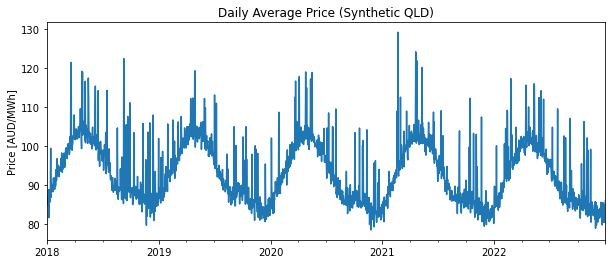

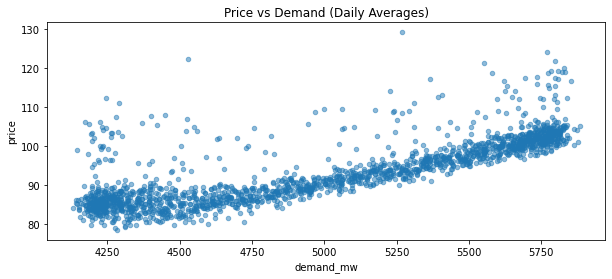

In [11]:
# 4. Quick EDA

# Price over time (sample)
df_sample = df.set_index("datetime").resample("D").mean()  # daily average
df_sample["price"].plot()
plt.title("Daily Average Price (Synthetic QLD)")
plt.ylabel("Price [AUD/MWh]")
plt.xlabel("")
plt.show()

# Demand vs Price scatter (sample)
df_sample.plot.scatter(x="demand_mw", y="price", alpha=0.5)
plt.title("Price vs Demand (Daily Averages)")
plt.show()



In [12]:
# 5. Feature engineering

df = df.set_index("datetime")

# Lags
df["price_lag_1"]   = df["price"].shift(1)
df["price_lag_48"]  = df["price"].shift(48)   # previous day (30-min data)
df["demand_lag_1"]  = df["demand_mw"].shift(1)

# Time features
df["hour"]      = df.index.hour + df.index.minute / 60
df["dayofweek"] = df.index.dayofweek
df["month"]     = df.index.month

# Interaction-ish feature: demand level bucket
df["demand_bucket"] = pd.qcut(df["demand_mw"], 4, labels=[0,1,2,3])

# Drop rows with NaN from lags
df_model = df.dropna().copy()


In [13]:
# 6. Train-test split (time-based)

# Use last year as test
split_date = df_model.index.max() - pd.DateOffset(years=1)
train = df_model[df_model.index <= split_date]
test  = df_model[df_model.index  > split_date]

feature_cols = [
    "price_lag_1",
    "price_lag_48",
    "demand_mw",
    "demand_lag_1",
    "temperature_c",
    "renewable_share",
    "hour",
    "dayofweek",
    "month",
    "demand_bucket",
]

X_train = train[feature_cols]
y_train = train["price"]
X_test  = test[feature_cols]
y_test  = test["price"]

In [14]:
# 7. Naive baseline (y_pred = last price)

y_pred_naive = test["price_lag_1"]

mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = mean_squared_error(y_test, y_pred_naive, squared=False)

print("Naive baseline:")
print("  MAE :", mae_naive)
print("  RMSE:", rmse_naive)


Naive baseline:
  MAE : 14.860883555714652
  RMSE: 44.50783784666586


In [15]:
# 8. Linear Regression model

lin = LinearRegression()
lin.fit(X_train, y_train)

y_pred_lin = lin.predict(X_test)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = mean_squared_error(y_test, y_pred_lin, squared=False)

print("\nLinear Regression:")
print("  MAE :", mae_lin)
print("  RMSE:", rmse_lin)




Linear Regression:
  MAE : 9.860271714873758
  RMSE: 31.48438264039015


In [16]:
# 9. Random Forest model

rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=12,
    n_jobs=-1,
    random_state=42,
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

print("\nRandom Forest:")
print("  MAE :", mae_rf)
print("  RMSE:", rmse_rf)



Random Forest:
  MAE : 9.84453711801115
  RMSE: 32.06516192424835


In [17]:
# 10. Compare models

results = pd.DataFrame({
    "model": ["naive", "linear", "random_forest"],
    "MAE": [mae_naive, mae_lin, mae_rf],
    "RMSE": [rmse_naive, rmse_lin, rmse_rf],
})
print("\nModel comparison:")
print(results)



Model comparison:
           model        MAE       RMSE
0          naive  14.860884  44.507838
1         linear   9.860272  31.484383
2  random_forest   9.844537  32.065162


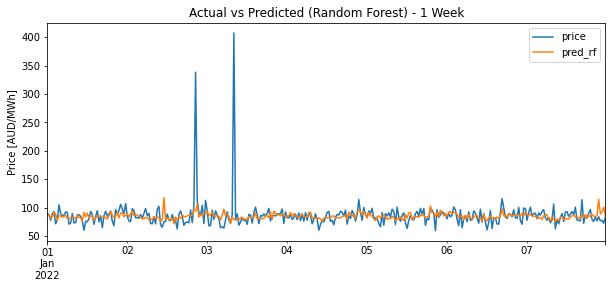

In [18]:
# 11. Plot Actual vs Predicted (Random Forest on a sample period)

test_plot = test.copy()
test_plot["pred_rf"] = y_pred_rf

sample = test_plot.iloc[:48*7]  # one week

sample[["price", "pred_rf"]].plot()
plt.title("Actual vs Predicted (Random Forest) - 1 Week")
plt.ylabel("Price [AUD/MWh]")
plt.xlabel("")
plt.show()



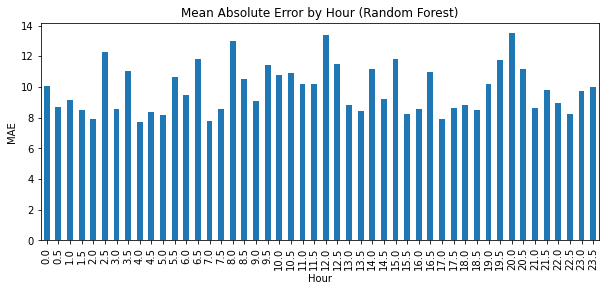

In [19]:
# 12. Error by hour-of-day (for Random Forest)

test_errors = test.copy()
test_errors["error_rf"] = test_errors["price"] - y_pred_rf
hourly_error = test_errors.groupby("hour")["error_rf"].apply(lambda x: x.abs().mean())

hourly_error.plot(kind="bar")
plt.title("Mean Absolute Error by Hour (Random Forest)")
plt.ylabel("MAE")
plt.xlabel("Hour")
plt.show()


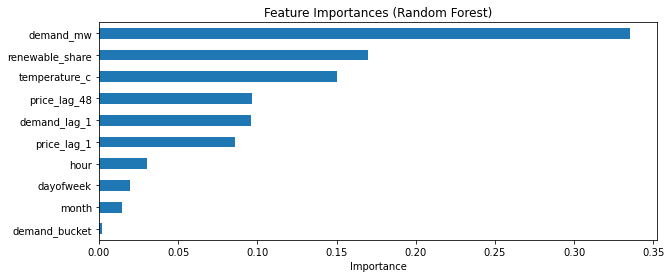

In [20]:
# 13. Feature importance (Random Forest)
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=True).plot(kind="barh")
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()